In [1]:
# Environment setup  
import subprocess  
import pyspark
import dxpy  
import dxdata  
import pandas as pd  
import os  
import glob
import pyspark.pandas as ps

# for stats
import databricks.koalas as ks
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

[root] WARNING: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
[root] WARNING: Found pyspark version "3.2.3" installed. The pyspark version 3.2 and above has a built-in "pandas APIs on Spark" module ported from Koalas. Try `import pyspark.pandas as ps` instead. 


In [2]:
# Initialize Spark  
# Spark initialization (Done only once; do not rerun this cell unless you select Kernel -> Restart kernel).  
sc = pyspark.SparkContext()  
spark = pyspark.sql.SparkSession(sc)

In [3]:
# Automatically discover dispensed dataset ID and load the dataset
dispensed_dataset = dxpy.find_one_data_object(
    typename="Dataset", 
    name="app*.dataset", 
    folder="/", 
    name_mode="glob")
dispensed_dataset_id = dispensed_dataset["id"]
dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [4]:
participant = dataset['participant']

In [9]:
# Specify fields ID to retrieve, get corresponding UKB RAP field names and print description table.  
field_ids = ['31', '21001', '21022', '21000', '20116', '22189', '4080_i0_a0', '4080_i0_a1', '4079_i0_a0', '4079_i0_a1', '93_i0_a0', '93_i0_a1', '94_i0_a0', '94_i0_a1', '53', '131286', '131287']

In [10]:
# This function is used to grab all field names (e.g. "p<field_id>_iYYY_aZZZ") of a list of field IDs  
def fields_for_id(field_id):
    from distutils.version import LooseVersion
    field_id = str(field_id)
    fields = participant.find_fields(name_regex=r'^p{}(_i\d+)?(_a\d+)?$'.format(field_id))
    return sorted(fields, key=lambda f: LooseVersion(f.name))

fields = [fields_for_id(f)[0] for f in field_ids] + [participant.find_field(name='p20160_i0')] + [participant.find_field(name='eid')]  
field_description = pd.DataFrame({
    'Field': [f.name for f in fields],
    'Title': [f.title for f in fields],
    'Coding': [f.coding.codes if f.coding is not None else '' for f in fields ]
})  
field_description

/tmp/ipykernel_1745/3851626384.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return sorted(fields, key=lambda f: LooseVersion(f.name))


,Field,Title,Coding
0,p31,Sex,"{'0': 'Female', '1': 'Male'}"
1,p21001_i0,Body mass index (BMI) | Instance 0,
2,p21022,Age at recruitment,
3,p21000_i0,Ethnic background | Instance 0,"{'1': 'White', '1001': 'British', '1002': 'Iri..."
4,p20116_i0,Smoking status | Instance 0,"{'-3': 'Prefer not to answer', '0': 'Never', '..."
5,p22189,Townsend deprivation index at recruitment,
6,p4080_i0_a0,"Systolic blood pressure, automated reading | I...",
7,p4080_i0_a1,"Systolic blood pressure, automated reading | I...",
8,p4079_i0_a0,"Diastolic blood pressure, automated reading | ...",
9,p4079_i0_a1,"Diastolic blood pressure, automated reading | ...",


In [14]:
# Define the connection
engine = dxdata.connect(
    dialect="hive+pyspark",
    connect_args={
        'config': {
            'spark.kryoserializer.buffer.max': '256m',
            'spark.sql.autoBroadcastJoinThreshold': '-1'
        }
    }
)

# Retrieve data for all participants
df = participant.retrieve_fields(
    fields=fields,  # Use the previously defined 'fields' list
    engine=engine,
    coding_values='replace'  # TEXT NOT NUMBERS
).toPandas()  # Convert the result to a pandas DataFrame

# Define the renaming dictionary
rename_dict = {
    'eid': 'IID',
    'p31': 'sex',
    'p21001_i0': 'BMI',
    'p21022': 'age',
    'p21000_i0': 'ethnic_background',
    'p20116_i0': 'smoking_status',
    'p22189': 'townsend_deprivation_index',
    'p4080_i0_a0': 'systolic_bp_auto_0',
    'p4080_i0_a1': 'systolic_bp_auto_1',
    'p4079_i0_a0': 'diastolic_bp_auto_0',
    'p4079_i0_a1': 'diastolic_bp_auto_1',
    'p93_i0_a0': 'systolic_bp_manual_0',
    'p93_i0_a1': 'systolic_bp_manual_1',
    'p94_i0_a0': 'diastolic_bp_manual_0',
    'p94_i0_a1': 'diastolic_bp_manual_1',
    'p53_i0': 'assessment_date',
    'p131286': 'I10_first_reported_date',
    'p131287': 'I10_report_source',
    'p20160_i0': 'ever_smoked'
}

# Rename the columns
df = df.rename(columns=rename_dict)

# Display the first few rows of the DataFrame
print("DataFrame:")
print(df.head())

# Display basic information about the DataFrame
print("\nDataFrame Info:")
df.info()

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())


DataFrame:
      sex      BMI  age ethnic_background smoking_status  \
0    Male  22.4393   62           British          Never   
1  Female  27.2545   63           British          Never   
2  Female  19.7754   62           British          Never   
3  Female  22.9684   68           British          Never   
4    Male  26.3224   58           British        Current   

   townsend_deprivation_index  systolic_bp_auto_0  systolic_bp_auto_1  \
0                        0.87               135.0               132.0   
1                       -3.49               142.0               122.0   
2                       -4.50               107.0                99.0   
3                       -5.65                 NaN                 NaN   
4                       -3.78               138.0               133.0   

   diastolic_bp_auto_0  diastolic_bp_auto_1  systolic_bp_manual_0  \
0                 81.0                 82.0                   NaN   
1                 84.0                 93.0        

In [21]:
# check
df

,sex,BMI,age,ethnic_background,smoking_status,townsend_deprivation_index,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,systolic_bp_manual_0,systolic_bp_manual_1,diastolic_bp_manual_0,diastolic_bp_manual_1,assessment_date,I10_first_reported_date,I10_report_source,ever_smoked,IID
0,Male,22.4393,62,British,Never,0.87,135.0,132.0,81.0,82.0,NaN,NaN,NaN,NaN,2008-08-06,None,None,No,1000104
1,Female,27.2545,63,British,Never,-3.49,142.0,122.0,84.0,93.0,NaN,NaN,NaN,NaN,2008-12-19,None,None,No,1000146
2,Female,19.7754,62,British,Never,-4.50,107.0,99.0,57.0,53.0,NaN,NaN,NaN,NaN,2010-04-09,None,None,No,1000172
3,Female,22.9684,68,British,Never,-5.65,NaN,NaN,NaN,NaN,148.0,145.0,82.0,84.0,2008-06-05,2018-08-20,Hospital admissions data only,No,1000189
4,Male,26.3224,58,British,Current,-3.78,138.0,133.0,80.0,78.0,NaN,NaN,NaN,NaN,2010-06-05,None,None,Yes,1000254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502132,Male,23.5262,54,British,Previous,-0.01,130.0,132.0,79.0,72.0,NaN,NaN,NaN,NaN,2009-02-11,None,None,Yes,6022095
502133,Female,24.9827,44,British,Never,-3.62,135.0,134.0,78.0,79.0,NaN,NaN,NaN,NaN,2008-07-19,None,None,No,6022116
502134,Male,24.4637,51,British,Previous,-2.77,139.0,NaN,87.0,NaN,NaN,149.0,NaN,96.0,2006-03-25,2022-09-14,Hospital admissions data only,Yes,6022187
502135,Male,29.4457,57,British,Previous,-3.35,128.0,136.0,83.0,86.0,NaN,NaN,NaN,NaN,2008-10-11,1993-03-01,Self-report only,Yes,6022222


In [23]:
# group ethnicity to top levels - Asian, Black, White, Mixed, Other 
# white - British, Irish, Any other white background
# mixed - White and Black Caribbean, White and Black African, White and Asian, Any other mixed background
# Asian - Indian, Pakistani, Bangladeshi, Any other Asian background
# Black -Caribbean, African, Any other Black background
# other - Chinese, Other ethnic group, Do not know, Prefer not to answer

ethnicity_mapping = {
    # White
    'British': 'White',
    'Irish': 'White',
    'Any other white background': 'White',
    
    # Mixed
    'White and Black Caribbean': 'Mixed',
    'White and Black African': 'Mixed',
    'White and Asian': 'Mixed',
    'Any other mixed background': 'Mixed',
    
    # Asian
    'Asian or Asian British' : 'Asian',
    'Indian': 'Asian',
    'Pakistani': 'Asian',
    'Bangladeshi': 'Asian',
    'Any other Asian background': 'Asian',
    
    # Black
    'Black or Black British' : 'Black',
    'Caribbean': 'Black',
    'African': 'Black',
    'Any other Black background': 'Black',
    
    # Other
    'Chinese': 'Other',
    'Other ethnic group': 'Other',
    'Do not know': 'Other',
    'Prefer not to answer': 'Other'
}

# Apply the mapping to the ethnicity column
df['ethnic_background'] = df['ethnic_background'].replace(ethnicity_mapping)

# Verify the changes
print(df['ethnic_background'].value_counts())


ethnic_background
White    472369
Asian      9872
Black      8048
Other      8000
Mixed      2950
Name: count, dtype: int64


In [25]:
df

,sex,BMI,age,ethnic_background,smoking_status,townsend_deprivation_index,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,systolic_bp_manual_0,systolic_bp_manual_1,diastolic_bp_manual_0,diastolic_bp_manual_1,assessment_date,I10_first_reported_date,I10_report_source,ever_smoked,IID
0,Male,22.4393,62,White,Never,0.87,135.0,132.0,81.0,82.0,NaN,NaN,NaN,NaN,2008-08-06,None,None,No,1000104
1,Female,27.2545,63,White,Never,-3.49,142.0,122.0,84.0,93.0,NaN,NaN,NaN,NaN,2008-12-19,None,None,No,1000146
2,Female,19.7754,62,White,Never,-4.50,107.0,99.0,57.0,53.0,NaN,NaN,NaN,NaN,2010-04-09,None,None,No,1000172
3,Female,22.9684,68,White,Never,-5.65,NaN,NaN,NaN,NaN,148.0,145.0,82.0,84.0,2008-06-05,2018-08-20,Hospital admissions data only,No,1000189
4,Male,26.3224,58,White,Current,-3.78,138.0,133.0,80.0,78.0,NaN,NaN,NaN,NaN,2010-06-05,None,None,Yes,1000254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502132,Male,23.5262,54,White,Previous,-0.01,130.0,132.0,79.0,72.0,NaN,NaN,NaN,NaN,2009-02-11,None,None,Yes,6022095
502133,Female,24.9827,44,White,Never,-3.62,135.0,134.0,78.0,79.0,NaN,NaN,NaN,NaN,2008-07-19,None,None,No,6022116
502134,Male,24.4637,51,White,Previous,-2.77,139.0,NaN,87.0,NaN,NaN,149.0,NaN,96.0,2006-03-25,2022-09-14,Hospital admissions data only,Yes,6022187
502135,Male,29.4457,57,White,Previous,-3.35,128.0,136.0,83.0,86.0,NaN,NaN,NaN,NaN,2008-10-11,1993-03-01,Self-report only,Yes,6022222


In [27]:
# Convert date columns to datetime
df['assessment_date'] = pd.to_datetime(df['assessment_date'])
df['I10_first_reported_date'] = pd.to_datetime(df['I10_first_reported_date'],errors='coerce')

# Filter out participants with no I10 date (NaN) and those with I10 date after assessment date
df_filtered = df[
    (df['I10_first_reported_date'].notna()) &  # Keep rows where I10 date is not NaN
    (df['I10_first_reported_date'] <= df['assessment_date'])  # Keep rows where I10 date is before or on assessment date
]

# Reset the index of the filtered DataFrame
df_filtered = df_filtered.reset_index(drop=True)

# Print the shape of the original and filtered DataFrames
print(f"Original DataFrame shape: {df.shape}")
print(f"Filtered DataFrame shape: {df_filtered.shape}")

# Display the first few rows of the filtered DataFrame
print("\nFiltered DataFrame:")
print(df_filtered.head())

# Display basic information about the filtered DataFrame
print("\nFiltered DataFrame Info:")
df_filtered.info()

# Display summary statistics for the filtered DataFrame
print("\nFiltered Summary Statistics:")
print(df_filtered.describe())


Original DataFrame shape: (502137, 19)
Filtered DataFrame shape: (134585, 19)

Filtered DataFrame:
      sex      BMI  age ethnic_background smoking_status  \
0  Female  30.5083   66             White          Never   
1    Male  31.7521   60             White          Never   
2    Male  26.9388   69             White       Previous   
3  Female  27.6324   50             White          Never   
4    Male  18.4414   59             White        Current   

   townsend_deprivation_index  systolic_bp_auto_0  systolic_bp_auto_1  \
0                        2.68               142.0               145.0   
1                       -5.45               147.0               130.0   
2                       -2.15               165.0               157.0   
3                       -1.73               130.0               126.0   
4                       -0.93               152.0               140.0   

   diastolic_bp_auto_0  diastolic_bp_auto_1  systolic_bp_manual_0  \
0                 90.0          

In [28]:
# Calculate average for systolic BP (auto)
df_filtered['SBP_auto_avg'] = df_filtered[['systolic_bp_auto_0', 'systolic_bp_auto_1']].mean(axis=1)

# Calculate average for diastolic BP (auto)
df_filtered['DBP_auto_avg'] = df_filtered[['diastolic_bp_auto_0', 'diastolic_bp_auto_1']].mean(axis=1)

# Calculate average for systolic BP (manual)
df_filtered['SBP_man_avg'] = df_filtered[['systolic_bp_manual_0', 'systolic_bp_manual_1']].mean(axis=1)

# Calculate average for diastolic BP (manual)
df_filtered['DBP_man_avg'] = df_filtered[['diastolic_bp_manual_0', 'diastolic_bp_manual_1']].mean(axis=1)


In [29]:
df_filtered

,sex,BMI,age,ethnic_background,smoking_status,townsend_deprivation_index,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,...,diastolic_bp_manual_1,assessment_date,I10_first_reported_date,I10_report_source,ever_smoked,IID,SBP_auto_avg,DBP_auto_avg,SBP_man_avg,DBP_man_avg
0,Female,30.5083,66,White,Never,2.68,142.0,145.0,90.0,94.0,...,NaN,2008-04-21,2001-02-01,Self-report only,Yes,1000370,143.5,92.0,NaN,NaN
1,Male,31.7521,60,White,Never,-5.45,147.0,130.0,82.0,82.0,...,NaN,2009-03-20,2004-02-01,Self-report and other source(s),Yes,1000706,138.5,82.0,NaN,NaN
2,Male,26.9388,69,White,Previous,-2.15,165.0,157.0,92.0,90.0,...,NaN,2008-11-25,2005-07-01,Self-report and other source(s),Yes,1000948,161.0,91.0,NaN,NaN
3,Female,27.6324,50,White,Never,-1.73,130.0,126.0,87.0,87.0,...,NaN,2010-05-10,2006-11-01,Self-report and other source(s),No,1000950,128.0,87.0,NaN,NaN
4,Male,18.4414,59,White,Current,-0.93,152.0,140.0,93.0,94.0,...,NaN,2009-08-19,1995-04-01,Self-report and other source(s),Yes,1001127,146.0,93.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134580,Male,23.7011,51,White,Current,3.71,152.0,135.0,88.0,89.0,...,NaN,2007-07-23,1964-07-01,Self-report and other source(s),Yes,6021458,143.5,88.5,NaN,NaN
134581,Male,33.4640,65,White,Previous,-3.82,176.0,183.0,91.0,94.0,...,NaN,2008-11-19,2008-02-01,Self-report only,Yes,6021484,179.5,92.5,NaN,NaN
134582,Male,33.2976,60,White,Previous,-2.28,143.0,142.0,96.0,90.0,...,NaN,2009-03-16,1998-05-01,Self-report and other source(s),Yes,6021940,142.5,93.0,NaN,NaN
134583,Male,22.5694,60,Asian,Current,-1.54,131.0,136.0,91.0,94.0,...,NaN,2007-11-20,2007-05-01,Self-report and other source(s),Yes,6021994,133.5,92.5,NaN,NaN


In [30]:
# BP control column (1 is good control)
def bp_control(row):
    # Set SBP threshold based on age
    if row['age'] >= 80:
        sbp_threshold = 150  # Higher threshold for patients 80 and older
    else:
        sbp_threshold = 140  # Standard threshold for patients under 80
    
    dbp_threshold = 90  # DBP threshold is the same for all ages
    
    # Use auto readings if available, otherwise use manual readings
    sbp = row['SBP_auto_avg'] if not pd.isna(row['SBP_auto_avg']) else row['SBP_man_avg']
    dbp = row['DBP_auto_avg'] if not pd.isna(row['DBP_auto_avg']) else row['DBP_man_avg']
    
    # Check for missing data
    if pd.isna(sbp) or pd.isna(dbp):
        return pd.NA  # Return NaN if either SBP or DBP is missing
    elif sbp >= sbp_threshold or dbp >= dbp_threshold:
        return 0  # Bad BP control
    else:
        return 1  # Good BP control

# Apply the bp_control function to each row of the DataFrame
df_filtered['BP_control'] = df_filtered.apply(bp_control, axis=1)


In [31]:
df_filtered

,sex,BMI,age,ethnic_background,smoking_status,townsend_deprivation_index,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,...,assessment_date,I10_first_reported_date,I10_report_source,ever_smoked,IID,SBP_auto_avg,DBP_auto_avg,SBP_man_avg,DBP_man_avg,BP_control
0,Female,30.5083,66,White,Never,2.68,142.0,145.0,90.0,94.0,...,2008-04-21,2001-02-01,Self-report only,Yes,1000370,143.5,92.0,NaN,NaN,0
1,Male,31.7521,60,White,Never,-5.45,147.0,130.0,82.0,82.0,...,2009-03-20,2004-02-01,Self-report and other source(s),Yes,1000706,138.5,82.0,NaN,NaN,1
2,Male,26.9388,69,White,Previous,-2.15,165.0,157.0,92.0,90.0,...,2008-11-25,2005-07-01,Self-report and other source(s),Yes,1000948,161.0,91.0,NaN,NaN,0
3,Female,27.6324,50,White,Never,-1.73,130.0,126.0,87.0,87.0,...,2010-05-10,2006-11-01,Self-report and other source(s),No,1000950,128.0,87.0,NaN,NaN,1
4,Male,18.4414,59,White,Current,-0.93,152.0,140.0,93.0,94.0,...,2009-08-19,1995-04-01,Self-report and other source(s),Yes,1001127,146.0,93.5,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134580,Male,23.7011,51,White,Current,3.71,152.0,135.0,88.0,89.0,...,2007-07-23,1964-07-01,Self-report and other source(s),Yes,6021458,143.5,88.5,NaN,NaN,0
134581,Male,33.4640,65,White,Previous,-3.82,176.0,183.0,91.0,94.0,...,2008-11-19,2008-02-01,Self-report only,Yes,6021484,179.5,92.5,NaN,NaN,0
134582,Male,33.2976,60,White,Previous,-2.28,143.0,142.0,96.0,90.0,...,2009-03-16,1998-05-01,Self-report and other source(s),Yes,6021940,142.5,93.0,NaN,NaN,0
134583,Male,22.5694,60,Asian,Current,-1.54,131.0,136.0,91.0,94.0,...,2007-11-20,2007-05-01,Self-report and other source(s),Yes,6021994,133.5,92.5,NaN,NaN,0


In [32]:
# check numbers for BP control
bp_control_counts = df_filtered['BP_control'].value_counts()
print(bp_control_counts)

BP_control
0    91214
1    43067
Name: count, dtype: int64


In [33]:
# check how many have no control data
bp_control_missing = df_filtered['BP_control'].isna().sum()
print(f"Number of individuals with no BP control data: {bp_control_missing}")

Number of individuals with no BP control data: 304


In [34]:
# check no control data
rows_without_bp_control = df_filtered[df_filtered['BP_control'].isna()]
print(rows_without_bp_control)

           sex      BMI  age ethnic_background smoking_status  \
752       Male      NaN   68              None           None   
1307    Female  34.4922   55             White        Current   
1461      Male  34.7680   69             Black          Never   
1729    Female  44.3020   60             White          Never   
2095    Female  46.0465   55             White          Never   
...        ...      ...  ...               ...            ...   
133680  Female      NaN   56             White        Current   
133823    Male  31.2500   68             White          Never   
133926  Female  53.8189   67             White       Previous   
133948    Male      NaN   66             White        Current   
134564    Male      NaN   68              None           None   

        townsend_deprivation_index  systolic_bp_auto_0  systolic_bp_auto_1  \
752                           5.23                 NaN                 NaN   
1307                         -0.86                 NaN         

In [36]:
df_filtered_clean

,sex,BMI,age,ethnic_background,smoking_status,townsend_deprivation_index,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,...,assessment_date,I10_first_reported_date,I10_report_source,ever_smoked,IID,SBP_auto_avg,DBP_auto_avg,SBP_man_avg,DBP_man_avg,BP_control
0,Female,30.5083,66,White,Never,2.68,142.0,145.0,90.0,94.0,...,2008-04-21,2001-02-01,Self-report only,Yes,1000370,143.5,92.0,NaN,NaN,0
1,Male,31.7521,60,White,Never,-5.45,147.0,130.0,82.0,82.0,...,2009-03-20,2004-02-01,Self-report and other source(s),Yes,1000706,138.5,82.0,NaN,NaN,1
2,Male,26.9388,69,White,Previous,-2.15,165.0,157.0,92.0,90.0,...,2008-11-25,2005-07-01,Self-report and other source(s),Yes,1000948,161.0,91.0,NaN,NaN,0
3,Female,27.6324,50,White,Never,-1.73,130.0,126.0,87.0,87.0,...,2010-05-10,2006-11-01,Self-report and other source(s),No,1000950,128.0,87.0,NaN,NaN,1
4,Male,18.4414,59,White,Current,-0.93,152.0,140.0,93.0,94.0,...,2009-08-19,1995-04-01,Self-report and other source(s),Yes,1001127,146.0,93.5,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134580,Male,23.7011,51,White,Current,3.71,152.0,135.0,88.0,89.0,...,2007-07-23,1964-07-01,Self-report and other source(s),Yes,6021458,143.5,88.5,NaN,NaN,0
134581,Male,33.4640,65,White,Previous,-3.82,176.0,183.0,91.0,94.0,...,2008-11-19,2008-02-01,Self-report only,Yes,6021484,179.5,92.5,NaN,NaN,0
134582,Male,33.2976,60,White,Previous,-2.28,143.0,142.0,96.0,90.0,...,2009-03-16,1998-05-01,Self-report and other source(s),Yes,6021940,142.5,93.0,NaN,NaN,0
134583,Male,22.5694,60,Asian,Current,-1.54,131.0,136.0,91.0,94.0,...,2007-11-20,2007-05-01,Self-report and other source(s),Yes,6021994,133.5,92.5,NaN,NaN,0


In [35]:
# Remove rows where BP_control is NaN
df_filtered_clean = df_filtered.dropna(subset=['BP_control'])

# Print the number of rows before and after removal (should be 304)
print(f"Number of rows before removal: {len(df_filtered)}")
print(f"Number of rows after removal: {len(df_filtered_clean)}")
print(f"Number of rows removed: {len(df_filtered) - len(df_filtered_clean)}")

Number of rows before removal: 134585
Number of rows after removal: 134281
Number of rows removed: 304


In [56]:
# export cohort
df_filtered_clean.to_csv('BP_control_full.csv', index=False)

In [55]:
# Create two separate DataFrames
df_bp_control_good = df_filtered_clean[df_filtered_clean['BP_control'] == 1]
df_bp_control_bad = df_filtered_clean[df_filtered_clean['BP_control'] == 0]

# Export the good BP control cohort
df_bp_control_good.to_csv('BP_control_GOOD.csv', index=False, encoding='utf-8')

# Export the bad BP control cohort
df_bp_control_bad.to_csv('BP_control_BAD.csv', index=False, encoding='utf-8')

# Print the number of rows in each cohort
print(f"Number of rows in BP_control_GOOD: {len(df_bp_control_good)}")
print(f"Number of rows in BP_control_BAD: {len(df_bp_control_bad)}")

Number of rows in BP_control_GOOD: 43067
Number of rows in BP_control_BAD: 91214


In [59]:
%%bash
dx upload BP_control_GOOD.csv --path /BP_Control/BP_control_GOOD
dx upload BP_control_BAD.csv --path /BP_Control/BP_control_BAD

ID                                file-GxjqFfQJp2pxQZvybvYGg5Kv
Class                             file
Project                           project-GvV46q0Jp2pfP7yJjvYy8b5y
Folder                            /BP_Control
Name                              BP_control_GOOD
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Sun Dec 29 20:49:30 2024
Created by                        swmitchell
 via the job                      job-Gxjgp98Jp2pq53qXxxbxyZxp
Last modified                     Sun Dec 29 20:49:30 2024
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"
ID                                file-GxjqFfjJp2pk2fBPKx4zK2X5
Class                             file
Project                           project-G

In [39]:
# STATS

In [39]:
pip install tableone

Note: you may need to restart the kernel to use updated packages.


In [40]:
import tableone

In [41]:
from tableone import TableOne

In [42]:
columns = ['age', 'BMI', 'townsend_deprivation_index', 'SBP_auto_avg', 'DBP_auto_avg', 'sex', 'ethnic_background', 'ever_smoked', 'I10_report_source', 'BP_control']
continuous = ['age', 'BMI', 'townsend_deprivation_index', 'SBP_auto_avg', 'DBP_auto_avg']
categorical = ['sex', 'ethnic_background', 'ever_smoked', 'I10_report_source', 'BP_control']
groupby = 'BP_control'
nonnormal = ['age']
rename = {'BP_control': 'Blood Pressure Control', 'townsend_deprivation_index': 'TDI', 'ethnic_background': 'Ethnicity', 'I10_report_source': 'Diagnosis Source'}

In [43]:
# Reset the index of the DataFrame
df_reset = df_filtered_clean.reset_index(drop=True)

In [44]:
# Convert NaN values to 0 and ensure all values are strings
df_reset.fillna(0)

/tmp/ipykernel_1745/579143378.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reset.fillna(0)


,sex,BMI,age,ethnic_background,smoking_status,townsend_deprivation_index,systolic_bp_auto_0,systolic_bp_auto_1,diastolic_bp_auto_0,diastolic_bp_auto_1,...,assessment_date,I10_first_reported_date,I10_report_source,ever_smoked,IID,SBP_auto_avg,DBP_auto_avg,SBP_man_avg,DBP_man_avg,BP_control
0,Female,30.5083,66,White,Never,2.68,142.0,145.0,90.0,94.0,...,2008-04-21,2001-02-01,Self-report only,Yes,1000370,143.5,92.0,0.0,0.0,0
1,Male,31.7521,60,White,Never,-5.45,147.0,130.0,82.0,82.0,...,2009-03-20,2004-02-01,Self-report and other source(s),Yes,1000706,138.5,82.0,0.0,0.0,1
2,Male,26.9388,69,White,Previous,-2.15,165.0,157.0,92.0,90.0,...,2008-11-25,2005-07-01,Self-report and other source(s),Yes,1000948,161.0,91.0,0.0,0.0,0
3,Female,27.6324,50,White,Never,-1.73,130.0,126.0,87.0,87.0,...,2010-05-10,2006-11-01,Self-report and other source(s),No,1000950,128.0,87.0,0.0,0.0,1
4,Male,18.4414,59,White,Current,-0.93,152.0,140.0,93.0,94.0,...,2009-08-19,1995-04-01,Self-report and other source(s),Yes,1001127,146.0,93.5,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134276,Male,23.7011,51,White,Current,3.71,152.0,135.0,88.0,89.0,...,2007-07-23,1964-07-01,Self-report and other source(s),Yes,6021458,143.5,88.5,0.0,0.0,0
134277,Male,33.4640,65,White,Previous,-3.82,176.0,183.0,91.0,94.0,...,2008-11-19,2008-02-01,Self-report only,Yes,6021484,179.5,92.5,0.0,0.0,0
134278,Male,33.2976,60,White,Previous,-2.28,143.0,142.0,96.0,90.0,...,2009-03-16,1998-05-01,Self-report and other source(s),Yes,6021940,142.5,93.0,0.0,0.0,0
134279,Male,22.5694,60,Asian,Current,-1.54,131.0,136.0,91.0,94.0,...,2007-11-20,2007-05-01,Self-report and other source(s),Yes,6021994,133.5,92.5,0.0,0.0,0


In [45]:
import numpy as np
import pandas as pd

# Apply the conversion to all columns in df_reset
for column in df_reset.columns:
    df_reset[column] = np.where(pd.isnull(df_reset[column]), None, df_reset[column].astype(str))

# Print the data types of all columns after conversion
print(df_reset.dtypes)

# Print the first few rows to verify the changes
print(df_reset.head())

sex                           object
BMI                           object
age                           object
ethnic_background             object
smoking_status                object
townsend_deprivation_index    object
systolic_bp_auto_0            object
systolic_bp_auto_1            object
diastolic_bp_auto_0           object
diastolic_bp_auto_1           object
systolic_bp_manual_0          object
systolic_bp_manual_1          object
diastolic_bp_manual_0         object
diastolic_bp_manual_1         object
assessment_date               object
I10_first_reported_date       object
I10_report_source             object
ever_smoked                   object
IID                           object
SBP_auto_avg                  object
DBP_auto_avg                  object
SBP_man_avg                   object
DBP_man_avg                   object
BP_control                    object
dtype: object
      sex      BMI age ethnic_background smoking_status  \
0  Female  30.5083  66             Whit

In [46]:
cohort_breakdown = TableOne(df_reset, columns=columns, categorical=categorical, continuous=continuous, groupby=groupby, nonnormal=nonnormal, rename=rename, pval=True)

In [47]:
print(cohort_breakdown.tabulate(tablefmt = "fancy_grid"))

╒═══════════════════════════════╤══════════════════════════════════════════════╤═══════════╤══════════════════╤══════════════════╤══════════════════╤═══════════╕
│                               │                                              │ Missing   │ Overall          │ 0                │ 1                │ P-Value   │
╞═══════════════════════════════╪══════════════════════════════════════════════╪═══════════╪══════════════════╪══════════════════╪══════════════════╪═══════════╡
│ n                             │                                              │           │ 134281           │ 91214            │ 43067            │           │
├───────────────────────────────┼──────────────────────────────────────────────┼───────────┼──────────────────┼──────────────────┼──────────────────┼───────────┤
│ age, median [Q1,Q3]           │                                              │ 0         │ 61.0 [55.0,65.0] │ 61.0 [56.0,65.0] │ 61.0 [55.0,65.0] │ <0.001    │
├───────────────────────────

In [48]:
cohort_breakdown

Grouped by Blood Pressure Control                                                              
                                                                                                     Missing           Overall                 0                 1 P-Value
n                                                                                                                       134281             91214             43067        
age, median [Q1,Q3]                                                                                        0  61.0 [55.0,65.0]  61.0 [56.0,65.0]  61.0 [55.0,65.0]  <0.001
BMI, mean (SD)                                                                                           830        29.4 (5.2)        29.4 (5.2)        29.5 (5.3)   0.033
TDI, mean (SD)                                                                                           162        -1.1 (3.2)        -1.2 (3.1)        -0.8 (3.3)  <0.001
SBP_auto_avg, mean (SD)                                                                                 7797      147.1 (18.3)      156.1 (14.4)       128.1 (8.7)  <0.001
DBP_auto_avg, mean (SD)                                                                                 7795       86.0 (10.4)        89.8 (9.4)        78.0 (7.1)  <0.001
sex, n (%)                    Female                                                                              62814 (46.8)      41289 (45.3)      21525 (50.0)  <0.001
                              Male                                                                                71467 (53.2)      49925 (54.7)      21542 (50.0)        
Ethnicity, n (%)              Asian                                                                                 3010 (2.2)        1815 (2.0)        1195 (2.8)  <0.001
                              Black                                                                                 2901 (2.2)        1940 (2.1)         961 (2.2)        
                              Mixed                                                                                  649 (0.5)         426 (0.5)         223 (0.5)        
                              None                                                                                   129 (0.1)          69 (0.1)          60 (0.1)        
                              Other                                                                                 2062 (1.5)        1368 (1.5)         694 (1.6)        
                              White                                                                              125530 (93.5)      85596 (93.8)      39934 (92.7)        
ever_smoked, n (%)            No                                                                                  50279 (37.4)      34451 (37.8)      15828 (36.8)  <0.001
                              None                                                                                   778 (0.6)         504 (0.6)         274 (0.6)        
                              Yes                                                                                 83224 (62.0)      56259 (61.7)      26965 (62.6)        
Diagnosis Source, n (%)       Hospital admissions data and other source(s)                                          4184 (3.1)        2631 (2.9)        1553 (3.6)  <0.001
                              Hospital admissions data only                                                         6503 (4.8)        3340 (3.7)        3163 (7.3)        
                              Primary care and other source(s)                                                      5462 (4.1)        3732 (4.1)        1730 (4.0)        
                              Primary care only                                                                      624 (0.5)         437 (0.5)         187 (0.4)        
                              Self-report and other source(s)                                                     87942 (65.5)      60775 (66.

In [50]:
cohort_breakdown.to_csv('cohort_breakdown.csv')

In [60]:
%%bash
dx upload cohort_breakdown.csv --path /BP_Control/Cohort_Breakdown

ID                                file-GxjqFk0Jp2pXKKBK4Gk33bXy
Class                             file
Project                           project-GvV46q0Jp2pfP7yJjvYy8b5y
Folder                            /BP_Control
Name                              Cohort_Breakdown
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Sun Dec 29 20:49:40 2024
Created by                        swmitchell
 via the job                      job-Gxjgp98Jp2pq53qXxxbxyZxp
Last modified                     Sun Dec 29 20:49:40 2024
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"


In [52]:
# GRAPHS

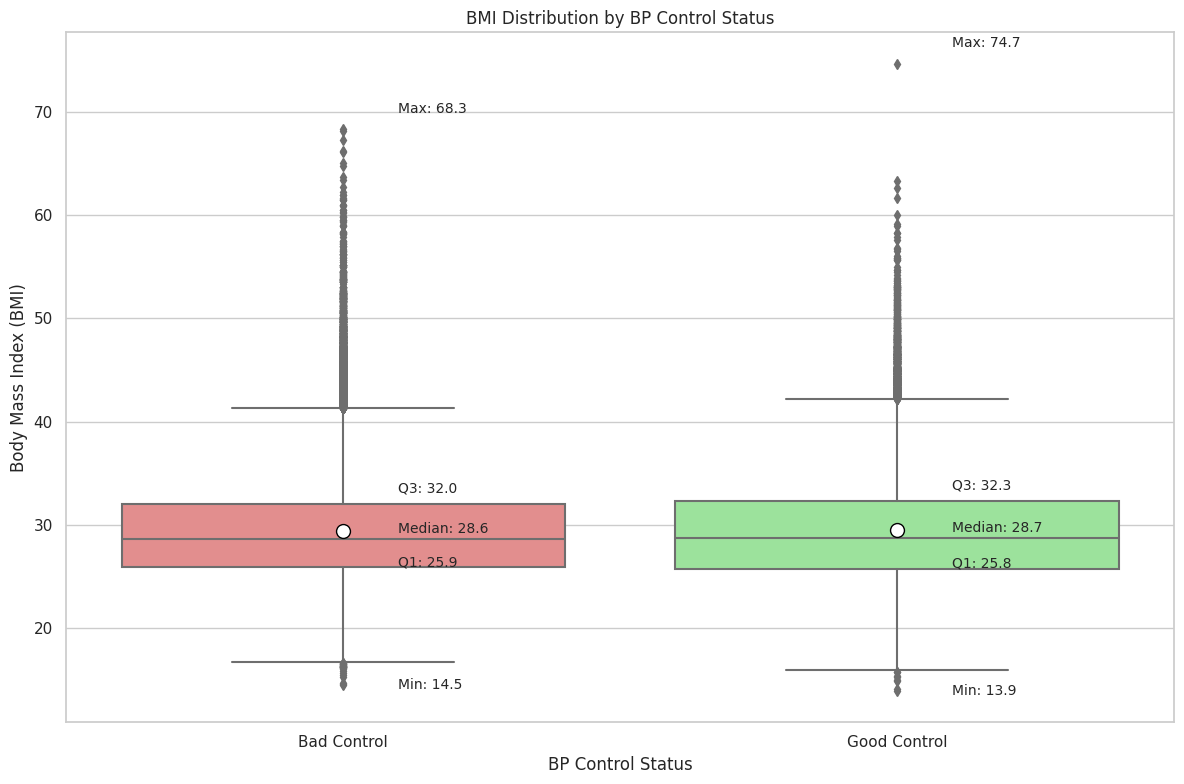

In [70]:
# BMI 
import seaborn as sns
import matplotlib.pyplot as plt

# load in df
df = df_filtered_clean.copy()

# Convert data types
df['BP_control'] = df['BP_control'].astype(int)
df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')  # Ensure BMI is numeric

# Drop rows with NaN values in BMI
df = df.dropna(subset=['BMI'])

# Plot settings
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Improve aesthetics

# Define a pastel color palette for the boxplot
palette = {0: 'lightcoral', 1: 'lightgreen'}  # Bad Control: red, Good Control: green

# Create the boxplot with custom colors and mean properties
ax = sns.boxplot(
    x='BP_control', 
    y='BMI', 
    data=df, 
    showmeans=True, 
    palette=palette,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10}  # Custom mean marker
)

plt.title('BMI Distribution by BP Control Status')
plt.xlabel('BP Control Status')
plt.ylabel('Body Mass Index (BMI)')
plt.xticks([0, 1], ['Bad Control', 'Good Control'])

# Calculate statistics for each group and add text annotations
for i, htn_group in enumerate([0, 1]):
    group_data = df[df['BP_control'] == htn_group]['BMI']
    stats = group_data.describe()
    
    # Add text annotations with slight adjustments for clarity
    offsets = [0, 0.5, 1, 1.5, 2]  # Adjust these offsets as necessary
    ax.text(i + 0.1, stats['min'] + offsets[0], f"Min: {stats['min']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['25%'] + offsets[1], f"Q1: {stats['25%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['50%'] + offsets[2], f"Median: {stats['50%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['75%'] + offsets[3], f"Q3: {stats['75%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['max'] + offsets[4], f"Max: {stats['max']:.1f}", ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()


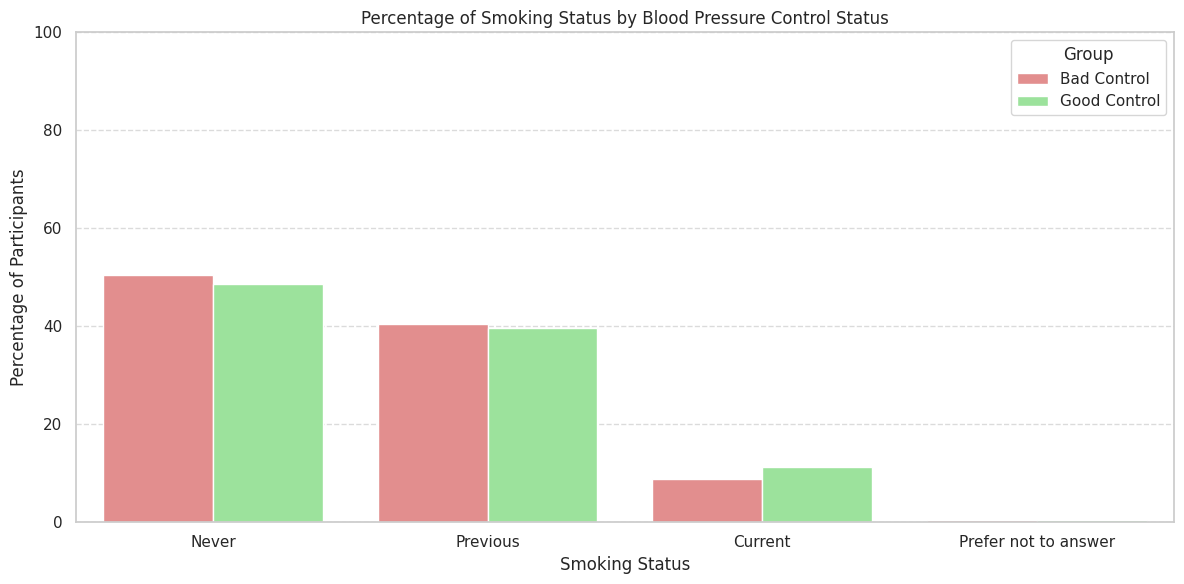

In [72]:
# Filter for bad and good blood pressure control
bad_control_df = df[df['BP_control'] == 0]  # Bad control
good_control_df = df[df['BP_control'] == 1]  # Good control

# Count occurrences of each smoking status
smoking_counts_bad_control = bad_control_df['smoking_status'].value_counts()
smoking_counts_good_control = good_control_df['smoking_status'].value_counts()

# Create a combined DataFrame
smoking_combined = pd.DataFrame({
    'Bad Control': smoking_counts_bad_control,
    'Good Control': smoking_counts_good_control
}).fillna(0)  # Fill NaN values with 0

# Calculate percentages
smoking_percentages_combined = (smoking_combined.div(smoking_combined.sum(axis=0), axis=1)) * 100

# Reset index to use smoking statuses as a column
smoking_percentages_combined = smoking_percentages_combined.reset_index()
smoking_percentages_combined.columns = ['Smoking Status', 'Bad Control', 'Good Control']

# Create a bar chart
plt.figure(figsize=(12, 6))  # Set figure size

# Melt the DataFrame for seaborn compatibility
smoking_melted = smoking_percentages_combined.melt(id_vars='Smoking Status', var_name='Group', value_name='Percentage')

# Define a custom color palette for the groups
palette = {'Bad Control': 'lightcoral', 'Good Control': 'lightgreen'}

# Plotting the grouped bar chart using seaborn
sns.barplot(x='Smoking Status', y='Percentage', hue='Group', data=smoking_melted, palette=palette)

# Add titles and labels
plt.title('Percentage of Smoking Status by Blood Pressure Control Status')
plt.xlabel('Smoking Status')
plt.ylabel('Percentage of Participants')

# Set y-axis limit to range from 0 to 100%
plt.ylim(0, 100)

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



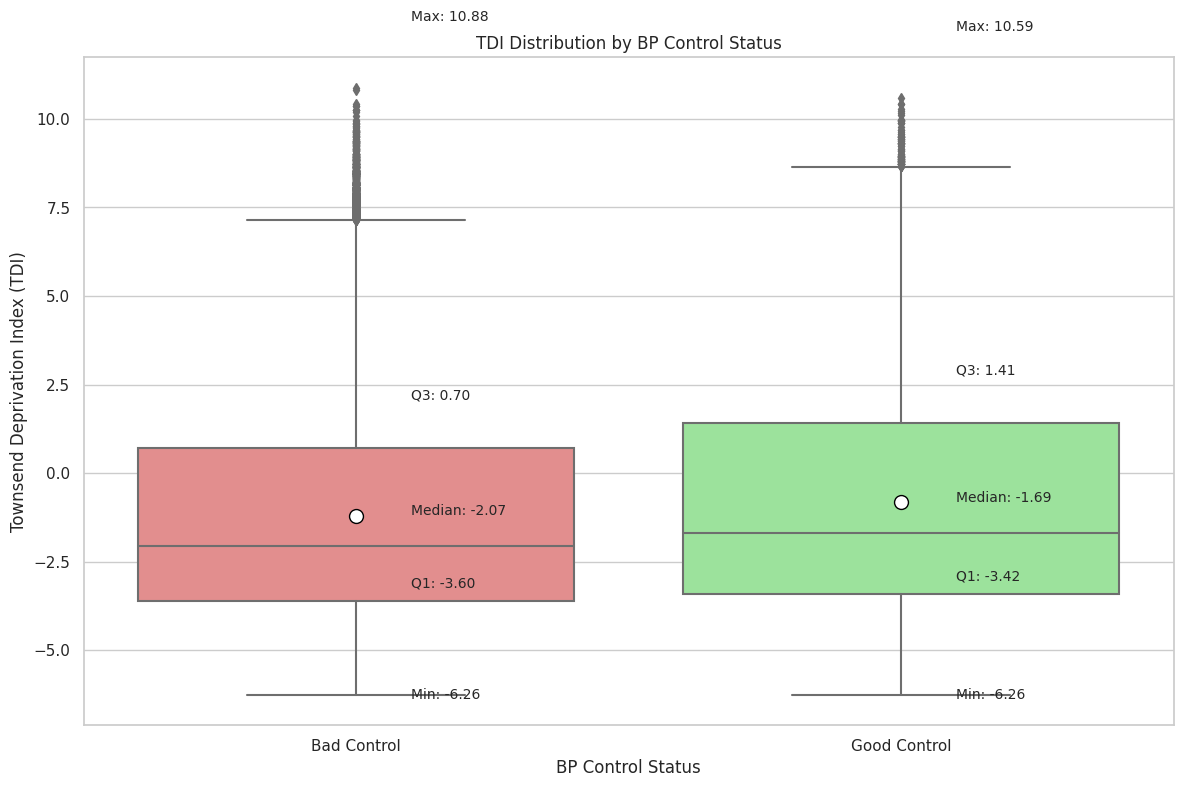

In [75]:
# TDI

# Convert data types
df['BP_control'] = df['BP_control'].astype(int)
df['tdi'] = pd.to_numeric(df['townsend_deprivation_index'], errors='coerce')  # Ensure TDI is numeric

# Drop rows with NaN values in TDI
df = df.dropna(subset=['tdi'])

# Plot settings
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Improve aesthetics

# Define a pastel color palette for the boxplot
palette = {0: 'lightcoral', 1: 'lightgreen'}  # Bad Control: red, Good Control: green

# Create the boxplot with custom colors and mean properties
ax = sns.boxplot(
    x='BP_control', 
    y='tdi', 
    data=df, 
    showmeans=True, 
    palette=palette,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10}  # Custom mean marker
)

plt.title('TDI Distribution by BP Control Status')
plt.xlabel('BP Control Status')
plt.ylabel('Townsend Deprivation Index (TDI)')
plt.xticks([0, 1], ['Bad Control', 'Good Control'])

# Calculate statistics for each group and add text annotations
for i, bp_group in enumerate([0, 1]):
    group_data = df[df['BP_control'] == bp_group]['tdi']
    stats = group_data.describe()
    
    # Add text annotations with slight adjustments for clarity
    offsets = [0, 0.5, 1, 1.5, 2]  # Adjust these offsets as necessary
    ax.text(i + 0.1, stats['min'] + offsets[0], f"Min: {stats['min']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['25%'] + offsets[1], f"Q1: {stats['25%']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['50%'] + offsets[2], f"Median: {stats['50%']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['75%'] + offsets[3], f"Q3: {stats['75%']:.2f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['max'] + offsets[4], f"Max: {stats['max']:.2f}", ha='left', va='center', fontsize=10)
    
plt.tight_layout()
plt.show()



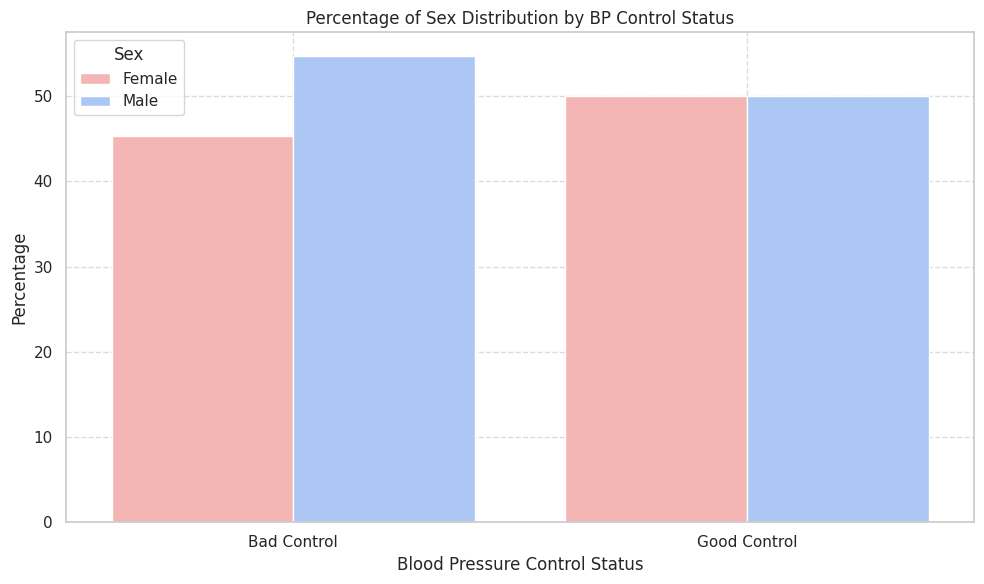

In [88]:
# control by sex 

# Load in df
df = df_filtered_clean.copy()

# Calculate counts of each sex within BP control groups
counts = df.groupby(['BP_control', 'sex']).size().reset_index(name='count')

# Calculate percentages
total_counts = counts.groupby('BP_control')['count'].transform('sum')
counts['percentage'] = (counts['count'] / total_counts) * 100

# Set the figure size
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Improve aesthetics

# Create the bar plot with percentages and custom colors
palette = {'Male': '#A0C4FF', 'Female': '#FFABAB'}  #  blue for Male, orange for Female
ax = sns.barplot(x='BP_control', y='percentage', hue='sex', data=counts, palette=palette)

# Add titles and labels
plt.title('Percentage of Sex Distribution by BP Control Status')
plt.xlabel('Blood Pressure Control Status')
plt.ylabel('Percentage')
plt.xticks([0, 1], ['Bad Control', 'Good Control'])  # Set x-tick labels

# Adjust legend title and labels manually
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Female', 'Male'], title='Sex')

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()





/opt/conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with

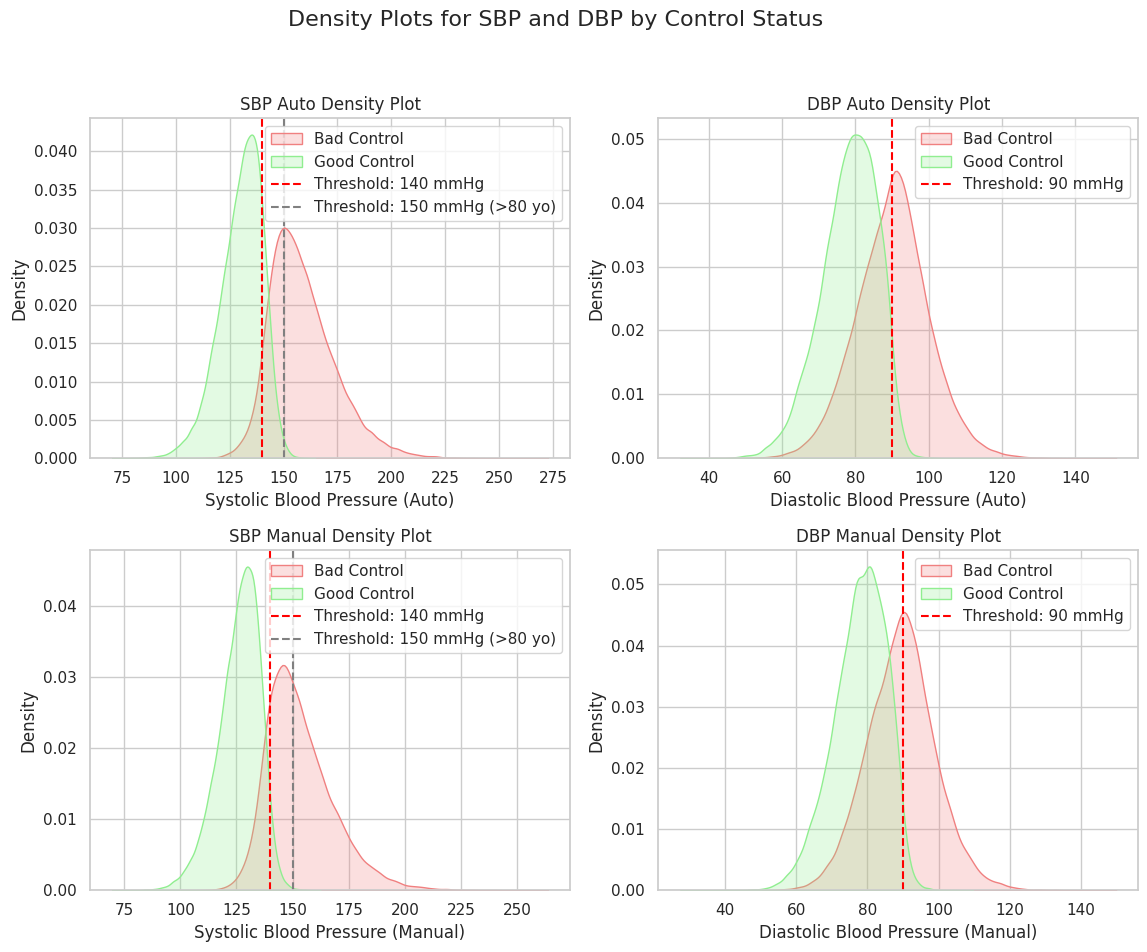

In [92]:
# density plots for blood pressure

# Load in df
df = df_filtered_clean.copy()

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Density Plots for SBP and DBP by Control Status', fontsize=16)

# SBP Auto Density Plot
sns.kdeplot(data=df[df['BP_control'] == 0], x='systolic_bp_auto_0', fill=True, color='lightcoral', label='Bad Control', ax=axes[0, 0])
sns.kdeplot(data=df[df['BP_control'] == 1], x='systolic_bp_auto_0', fill=True, color='lightgreen', label='Good Control', ax=axes[0, 0])
axes[0, 0].set_title('SBP Auto Density Plot')
axes[0, 0].set_xlabel('Systolic Blood Pressure (Auto)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
# Add threshold lines for SBP
axes[0, 0].axvline(x=140, color='red', linestyle='--', label='Threshold: 140 mmHg')
axes[0, 0].axvline(x=150, color='grey', linestyle='--', label='Threshold: 150 mmHg (>80 yo)')
axes[0, 0].legend()

# DBP Auto Density Plot
sns.kdeplot(data=df[df['BP_control'] == 0], x='diastolic_bp_auto_0', fill=True, color='lightcoral', label='Bad Control', ax=axes[0, 1])
sns.kdeplot(data=df[df['BP_control'] == 1], x='diastolic_bp_auto_0', fill=True, color='lightgreen', label='Good Control', ax=axes[0, 1])
axes[0, 1].set_title('DBP Auto Density Plot')
axes[0, 1].set_xlabel('Diastolic Blood Pressure (Auto)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
# Add threshold line for DBP
axes[0, 1].axvline(x=90, color='red', linestyle='--', label='Threshold: 90 mmHg')
axes[0, 1].legend()

# SBP Manual Density Plot
sns.kdeplot(data=df[df['BP_control'] == 0], x='systolic_bp_auto_1', fill=True, color='lightcoral', label='Bad Control', ax=axes[1, 0])
sns.kdeplot(data=df[df['BP_control'] == 1], x='systolic_bp_auto_1', fill=True, color='lightgreen', label='Good Control', ax=axes[1, 0])
axes[1, 0].set_title('SBP Manual Density Plot')
axes[1, 0].set_xlabel('Systolic Blood Pressure (Manual)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
# Add threshold lines for SBP Manual
axes[1, 0].axvline(x=140, color='red', linestyle='--', label='Threshold: 140 mmHg')
axes[1, 0].axvline(x=150, color='grey', linestyle='--', label='Threshold: 150 mmHg (>80 yo)')
axes[1, 0].legend()

# DBP Manual Density Plot
sns.kdeplot(data=df[df['BP_control'] == 0], x='diastolic_bp_auto_1', fill=True, color='lightcoral', label='Bad Control', ax=axes[1, 1])
sns.kdeplot(data=df[df['BP_control'] == 1], x='diastolic_bp_auto_1', fill=True, color='lightgreen', label='Good Control', ax=axes[1, 1])
axes[1, 1].set_title('DBP Manual Density Plot')
axes[1, 1].set_xlabel('Diastolic Blood Pressure (Manual)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
# Add threshold line for DBP Manual
axes[1, 1].axvline(x=90, color='red', linestyle='--', label='Threshold: 90 mmHg')
axes[1, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
plt.show()



/tmp/ipykernel_1745/272568052.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_bp_auto = df.groupby(['age_group', 'BP_control'])[['systolic_bp_auto_0', 'diastolic_bp_auto_0']].mean().unstack()
/tmp/ipykernel_1745/272568052.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_bp_manual = df.groupby(['age_group', 'BP_control'])[['systolic_bp_auto_1', 'diastolic_bp_auto_1']].mean().unstack()


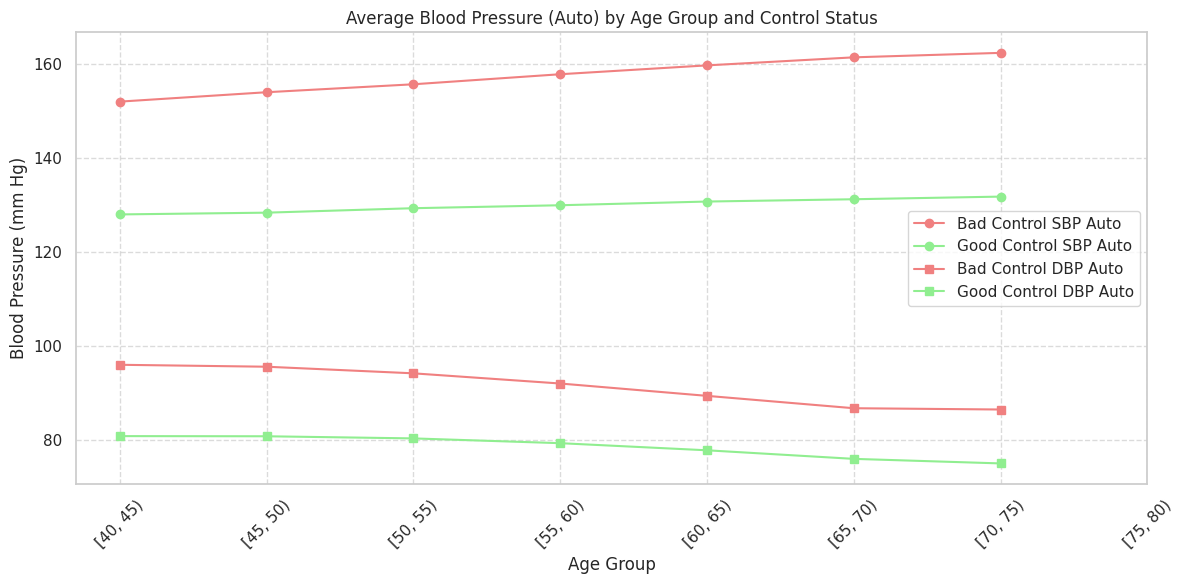

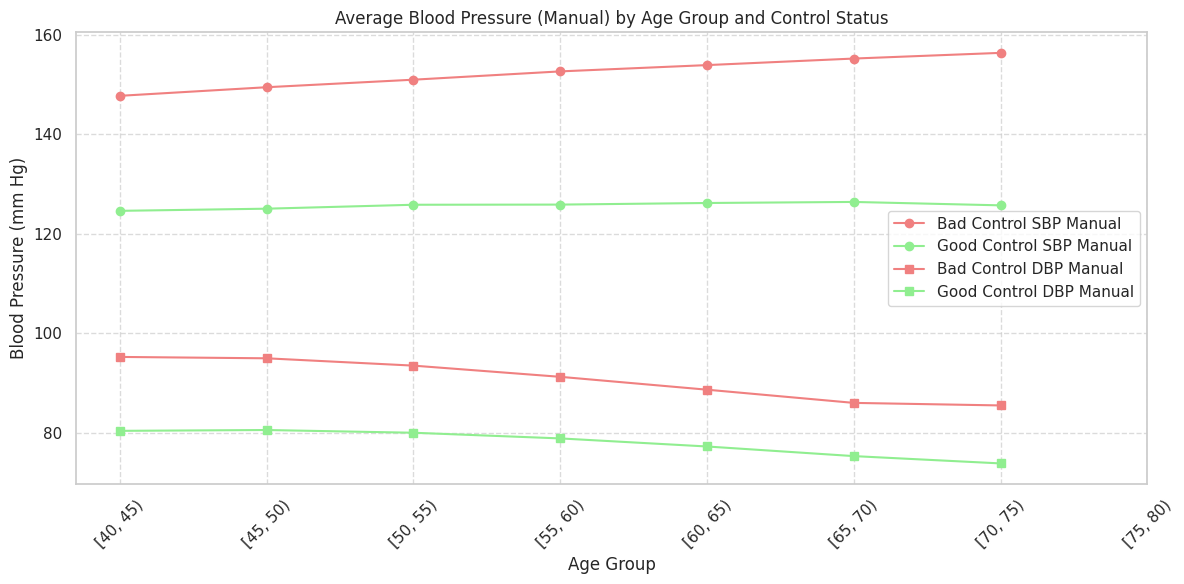

In [95]:
# age groups & BP by control group 

# Load in df
df = df_filtered_clean.copy()

# Convert SBP and DBP to numeric
df['systolic_bp_auto_0'] = pd.to_numeric(df['systolic_bp_auto_0'], errors='coerce')
df['diastolic_bp_auto_0'] = pd.to_numeric(df['diastolic_bp_auto_0'], errors='coerce')
df['systolic_bp_auto_1'] = pd.to_numeric(df['systolic_bp_auto_1'], errors='coerce')
df['diastolic_bp_auto_1'] = pd.to_numeric(df['diastolic_bp_auto_1'], errors='coerce')

# Create age groups
df['age_group'] = pd.cut(df['age'], bins=range(40, 85, 5), right=False)

# Calculate average BP for each age group and BP control status
avg_bp_auto = df.groupby(['age_group', 'BP_control'])[['systolic_bp_auto_0', 'diastolic_bp_auto_0']].mean().unstack()
avg_bp_manual = df.groupby(['age_group', 'BP_control'])[['systolic_bp_auto_1', 'diastolic_bp_auto_1']].mean().unstack()

# Set colors for good and bad control
colors = {0: 'lightcoral', 1: 'lightgreen'}  # Bad Control: red, Good Control: green

# Create the SBP and DBP Auto Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(avg_bp_auto)), avg_bp_auto['systolic_bp_auto_0'][0], color=colors[0], marker='o', label='Bad Control SBP Auto')
plt.plot(range(len(avg_bp_auto)), avg_bp_auto['systolic_bp_auto_0'][1], color=colors[1], marker='o', label='Good Control SBP Auto')

plt.plot(range(len(avg_bp_auto)), avg_bp_auto['diastolic_bp_auto_0'][0], color=colors[0], marker='s', label='Bad Control DBP Auto')
plt.plot(range(len(avg_bp_auto)), avg_bp_auto['diastolic_bp_auto_0'][1], color=colors[1], marker='s', label='Good Control DBP Auto')

plt.title('Average Blood Pressure (Auto) by Age Group and Control Status')
plt.xlabel('Age Group')
plt.ylabel('Blood Pressure (mm Hg)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(len(avg_bp_auto)), avg_bp_auto.index.get_level_values('age_group').astype(str), rotation=45)

plt.tight_layout()
plt.show()

# Create the SBP and DBP Manual Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(avg_bp_manual)), avg_bp_manual['systolic_bp_auto_1'][0], color=colors[0], marker='o', label='Bad Control SBP Manual')
plt.plot(range(len(avg_bp_manual)), avg_bp_manual['systolic_bp_auto_1'][1], color=colors[1], marker='o', label='Good Control SBP Manual')

plt.plot(range(len(avg_bp_manual)), avg_bp_manual['diastolic_bp_auto_1'][0], color=colors[0], marker='s', label='Bad Control DBP Manual')
plt.plot(range(len(avg_bp_manual)), avg_bp_manual['diastolic_bp_auto_1'][1], color=colors[1], marker='s', label='Good Control DBP Manual')

plt.title('Average Blood Pressure (Manual) by Age Group and Control Status')
plt.xlabel('Age Group')
plt.ylabel('Blood Pressure (mm Hg)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(len(avg_bp_manual)), avg_bp_manual.index.get_level_values('age_group').astype(str), rotation=45)

plt.tight_layout()
plt.show()


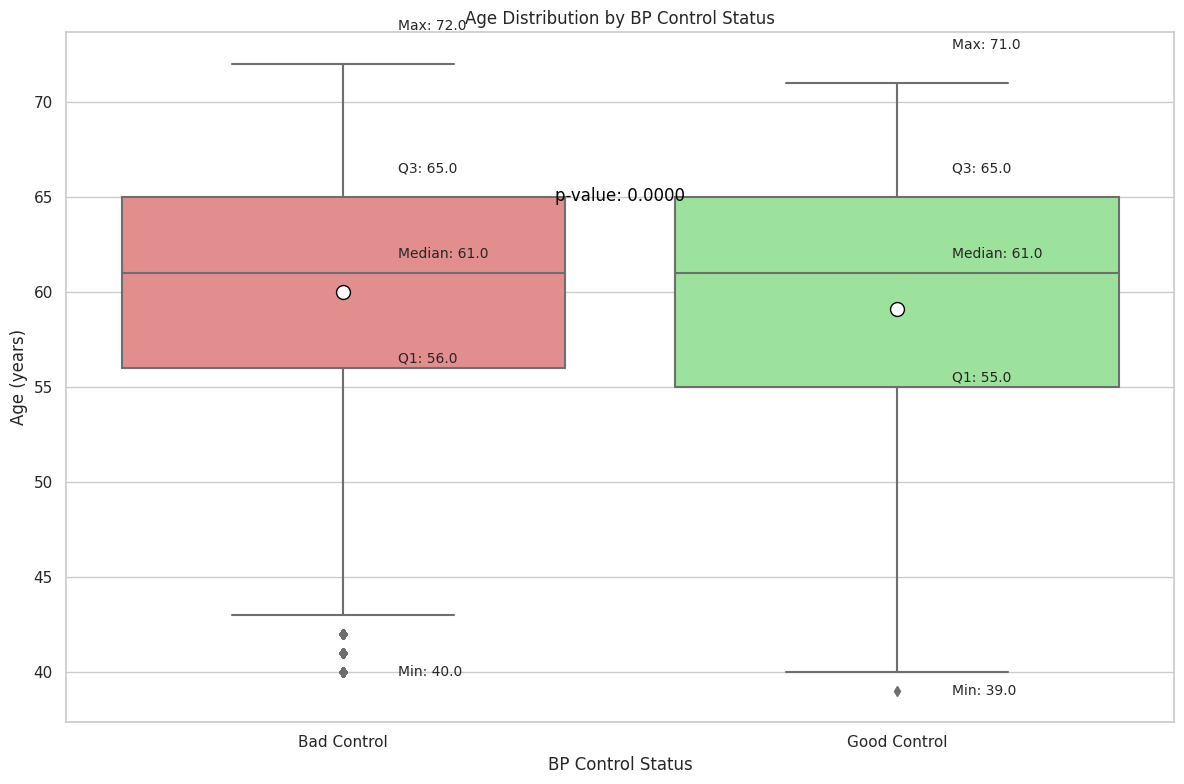

In [99]:
# age by control status
from scipy import stats

# Load in df
df = df_filtered_clean.copy()

# Convert data types
df['BP_control'] = df['BP_control'].astype(int)
df['age'] = pd.to_numeric(df['age'], errors='coerce')  # Ensure age is numeric

# Drop rows with NaN values in age
df = df.dropna(subset=['age'])

# Perform independent t-test to compare ages between good and bad control groups
bad_control_ages = df[df['BP_control'] == 0]['age']
good_control_ages = df[df['BP_control'] == 1]['age']

t_stat, p_value = stats.ttest_ind(bad_control_ages, good_control_ages)

# Plot settings
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")  # Improve aesthetics

# Define a pastel color palette for the boxplot
palette = {0: 'lightcoral', 1: 'lightgreen'}  # Bad Control: red, Good Control: green

# Create the boxplot with custom colors and mean properties
ax = sns.boxplot(
    x='BP_control', 
    y='age', 
    data=df, 
    showmeans=True, 
    palette=palette,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 10}  # Custom mean marker
)

plt.title('Age Distribution by BP Control Status')
plt.xlabel('BP Control Status')
plt.ylabel('Age (years)')
plt.xticks([0, 1], ['Bad Control', 'Good Control'])

# Add p-value annotation to the plot
ax.text(0.5, max(df['age']) * 0.9, f'p-value: {p_value:.4f}', ha='center', fontsize=12, color='black')

# Calculate statistics for each group and add text annotations
for i, bp_group in enumerate([0, 1]):
    group_data = df[df['BP_control'] == bp_group]['age']
    stats = group_data.describe()
    
    # Add text annotations with slight adjustments for clarity
    offsets = [0, 0.5, 1, 1.5, 2]  # Adjust these offsets as necessary
    ax.text(i + 0.1, stats['min'] + offsets[0], f"Min: {stats['min']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['25%'] + offsets[1], f"Q1: {stats['25%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['50%'] + offsets[2], f"Median: {stats['50%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['75%'] + offsets[3], f"Q3: {stats['75%']:.1f}", ha='left', va='center', fontsize=10)
    ax.text(i + 0.1, stats['max'] + offsets[4], f"Max: {stats['max']:.1f}", ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

plt.show()
